### Step 1. Examine the spectrum

In this tutorial, we will find the spectral trace (or spine) and then extract the spectra around them. The trace is needed because, in general, spectra are not perfectly aligned with the axes of a detector.

Let's start by importing the `extraction()` class from **easyspec**:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from easyspec.extraction import extraction
extraction = extraction()

easyspec-extraction version:  1.0.0


Now let's load our data. Notice that you can take the reddening for your target from this website: https://irsa.ipac.caltech.edu/applications/DUST/

In [91]:
!mkdir PKSJ0049-5738_results

/home/raniere/Documentos/easyspec/Tutorial/easyspec/cleaning/cleaning.py:719: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(image_data), origin='lower', cmap='gray')


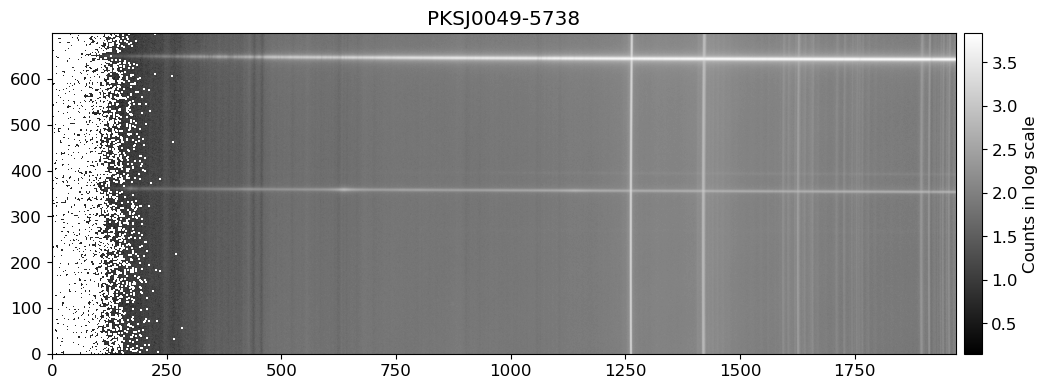

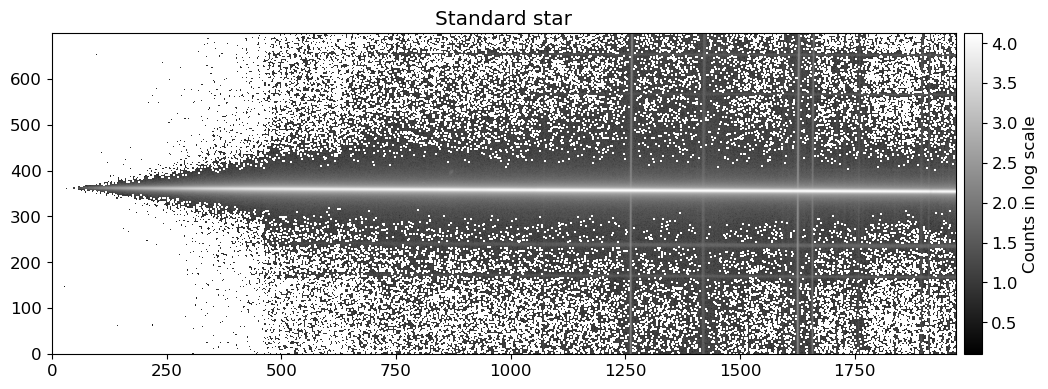

Returning both target and std star images...


In [5]:
output_directory = "./PKSJ0049-5738_results"
target_name = "PKSJ0049-5738"
std_star_file = "./master_standard_star.fits"
target_data_file = "./master_target_spec_PKSJ0049_5738.fits"
reddening = 0.0214
observatory = "ctio"

target_data, std_data = extraction.import_data(target_data_file,target_name, std_star_spec_file=std_star_file,plot=True)

The main goal of the trace is to obtain a model f(x) defining the vertical position of the light (the signal) along the detector.

### Step 2. Finding the spine

To obtain the trace, we first measure the maximum Y-value for each pixel column. We'll start with the method *multi*:

Total number of spectra:  2 , centered at y-pixels  [355 642]


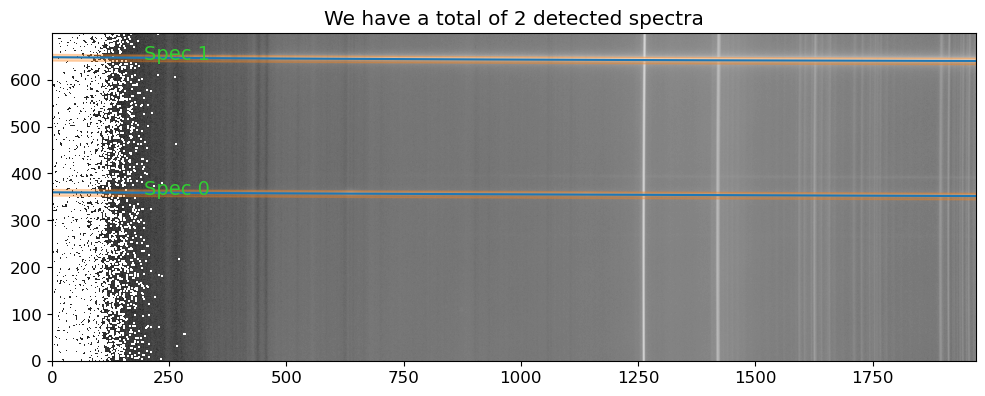

In [41]:
spine_list = extraction.tracing(target_data, method="multi", peak_height=150, distance=30,poly_order=2, xlims=[100,2000], y_pixel_range=10, plot_residuals=False, main_plot=True)

The function `extraction.tracing()` fits a polynomial to recover the trace/spine of one or several spectra in an image. The input variable **method** can be set as "argmax" or "moments" if you want to extract only the strongest spectrum in the image, or "multi" if you want to extract more than one spectrum (give it a try!).

The variables **peak_height** and **distance** set the required average height of each spectrum and the minimum distance (>= 1) among them in pixels in the y-axis (default is 20 pixels). The smaller is the value of **peak_height**, the more spectra you will find in your image, at the cost of including low S/N sources. E.g.: if you set **peak_height = 130**, ``easyspec`` will also detect the faint spectrum aboev *Spec 0*.

**poly_order** is the degree of the polynomial used to extract the trace.

**xlims** is useful only if **method = "argmax"** or **method = moments**. It sets the limits in the x-axis delimiting the region where we will look for the spectra.

Now we can use the trace (or traces) saved in **spine_list** to extract the spectrum (or spectra).

### Step 3. Spectral extraction

In the function `extraction.extracting()` below, we will extract the target and lamp spectra based on the traces computed in the previous step.

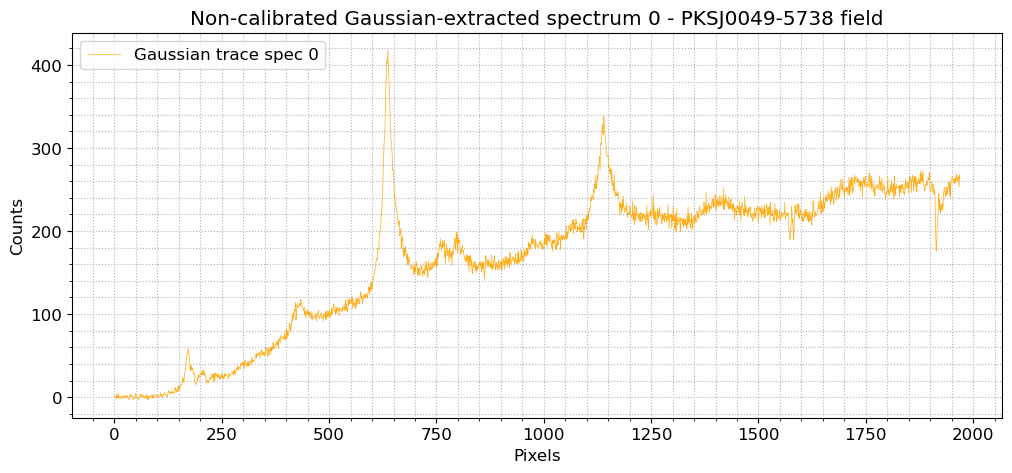

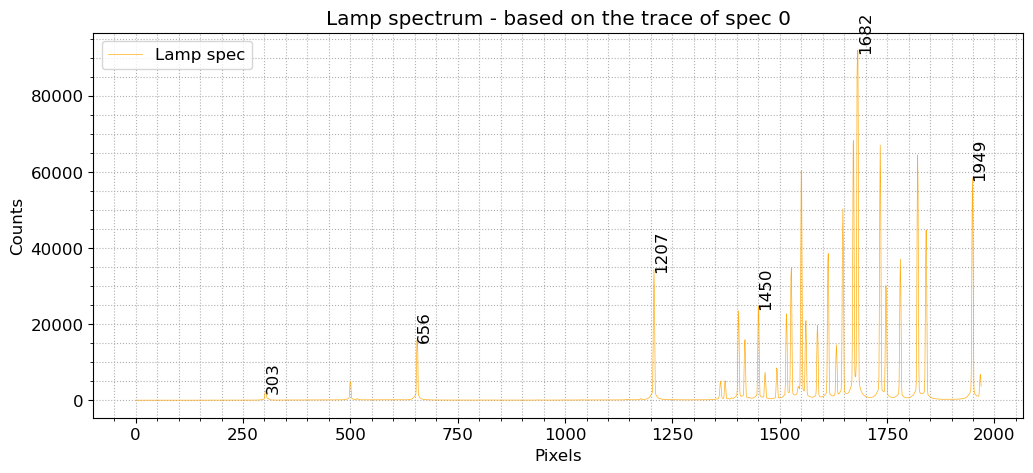

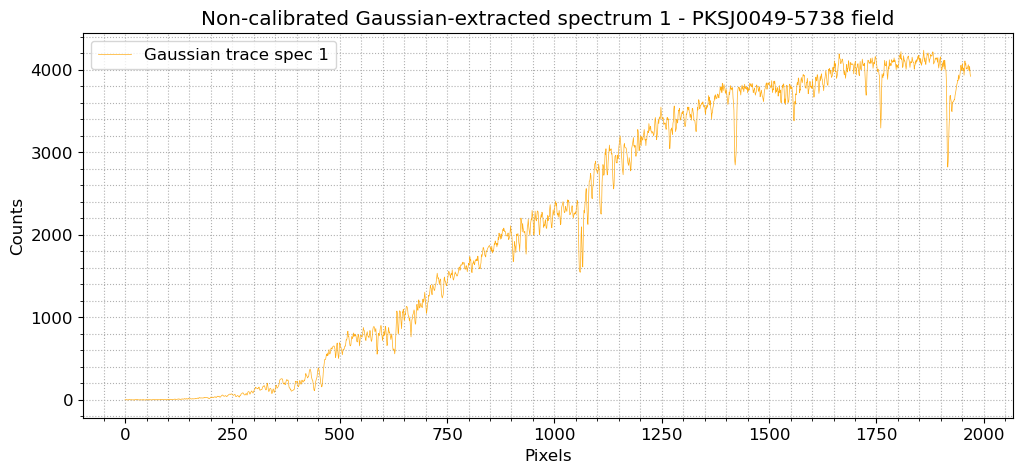

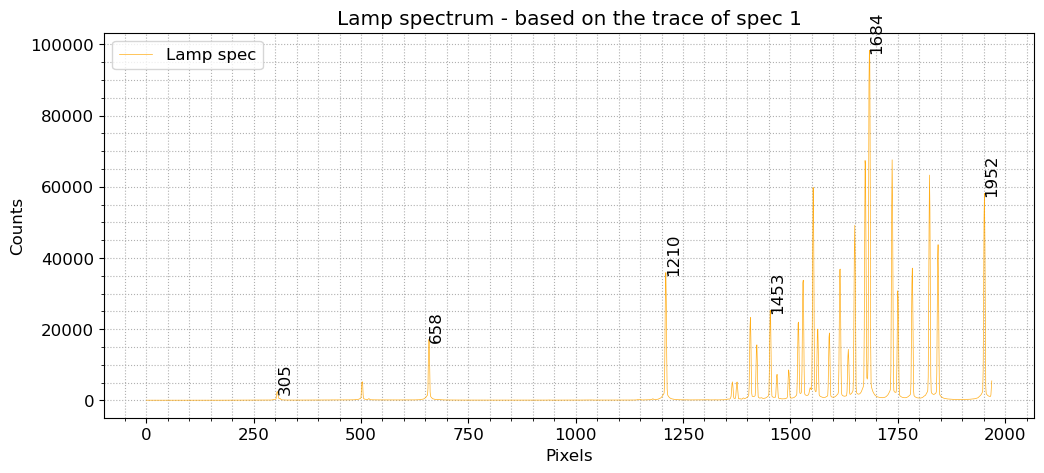

In [61]:
spec_extract_list, lamp_spec_list, lamp_peak_positions_list = extraction.extracting(target_data, spine_list, master_lamp_data="./master_lamp.fits", trace_half_width = 7, shift_y_pixels = 21, lamp_peak_height=1000, peak_distance = 160, diagnostic_plots = False, spec_plots = True)

Ok, these are the target and lamp non-calibrated spectra. We see that our blazar is the *Spec 0*, while *Spec 1* is a star that happened to fall within the slit. We will keep going this tutorial with both spectra.

Remember to set the master_lamp *.fits* file in the variable **master_lamp_data="./master_lamp.fits"**

**trace_half_width** = 7 is the The half-width of the trace in pixels. The spectra will be extracted within a region 2***trace_half_width** around their corresponding traces.

**shift_y_pixels** = 21: this is a very important parameter. It sets the vertical shift in the trace (in +- 21 pixels in this case) and repeat the extraction process to get the average sky spectrum around each trace.

**lamp_peak_height**=1000: The height of the lamp peaks (in counts and with respect to zero) to be detected.

**peak_distance** = 160: The minimum distance between peaks in pixels. Default is the length of the x-axis divided by 20.

**important note for multiple-trace analysis:** Note that the pixel values corresponding to the lamp peaks are slightly different for different traces. This is not a problem, however, when analyzing two or more spectra at the same time, you have to be sure that the same peaks are selected. Play with the parameters of the `extraction.extracting()` function to guarantee that this happens. This note can be ignored in case of single-trace analysis.

## Step 4. Wavelength calibration

In this step you will have to compare the results find above with the calibration lamp of the telescope you used. In the previous function, easyspec found 6 peaks (given the input conditions) for the lamp spectrum and saved them in the variable **lamp_peak_positions_list**. The more lines you use in this case, the better will be your calibration.

Since our data was observed with the SOAR Goodman spectrograph, we have to use the archival data for the Goodman lamps. In case you need references for the lamp peaks, here are some databases you can use (as of 12 September, 2024):
 * TNG DOLORES spectrograph reference lamps can be found in table 1 here: https://www.tng.iac.es/instruments/lrs/
 * SOAR Goodman Spectrograph Reference Lamp Library: https://soardocs.readthedocs.io/projects/lamps/en/latest/
 * Observatorio do Pico dos Dias (OPD-LNA) spectrographs: https://www.gov.br/lna/pt-br/composicao-1/coast/obs/opd/instrumentacao/instrumentos-e-detectores

### Optional

<span style="color:blue">If you don't want to use all of these lines, you can play with the parameters of the previous function such that it will give you fewer lines, or even reset lamp_peak_positions_list by hand. For instance, let's say you want to use only 5 out of the 6 lines found above. You can manualy reset the variable lamp_peak_positions_list by uncommenting the lines below:</span>.

In [63]:
lamp_peak_positions_list

[array([ 303,  656, 1207, 1450, 1682, 1949]),
 array([ 305,  658, 1210, 1453, 1684, 1952])]

In [52]:
#lamp_peak_positions_list[0] = [np.asarray([303,  656, 1207, 1450, 1949])]

<span style="color:blue">or even do something like this:</span>.

In [ ]:
#lamp_peak_positions_list = lamp_peak_positions_list[0]

<span style="color:blue">where you completely ignore the *Spec 1* trace.</span>.

### Back to the standard tutorial

Now you have to create a list with the wavelengths corresponding to these pixels based on the archival lamp data (which in our case is the Goodman 400 M1 HgArNe lamp):

In [64]:
corresponding_wavelengths = [3650.1580, 4358.3350, 5460.7500, 5944.8342, 6402.2480, 6929.4673]

Now we call the function `extraction.wavelength_calibration()` to calibrate the spectrum in wavelengths:

Spectrum 0:
Fit standard deviation = 0.6138507040378671 Angstrom
Spectrum 1:
Fit standard deviation = 0.3296479357747573 Angstrom


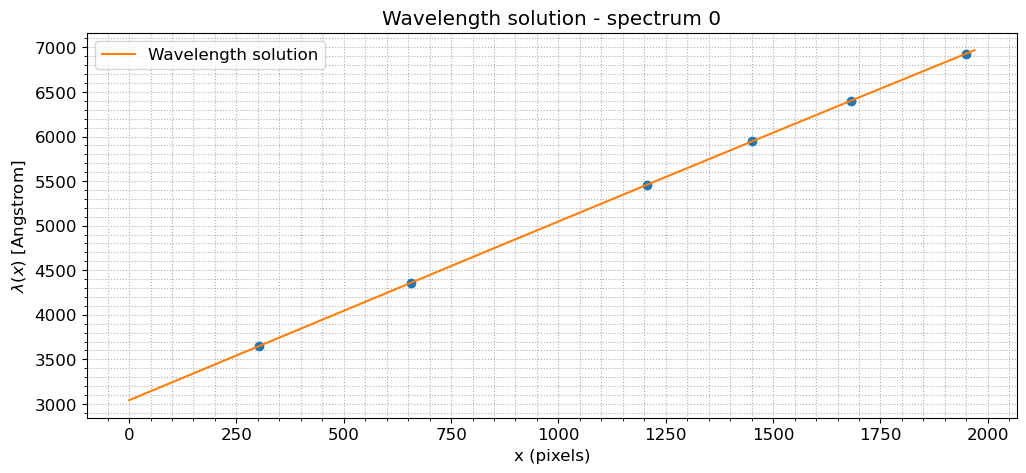

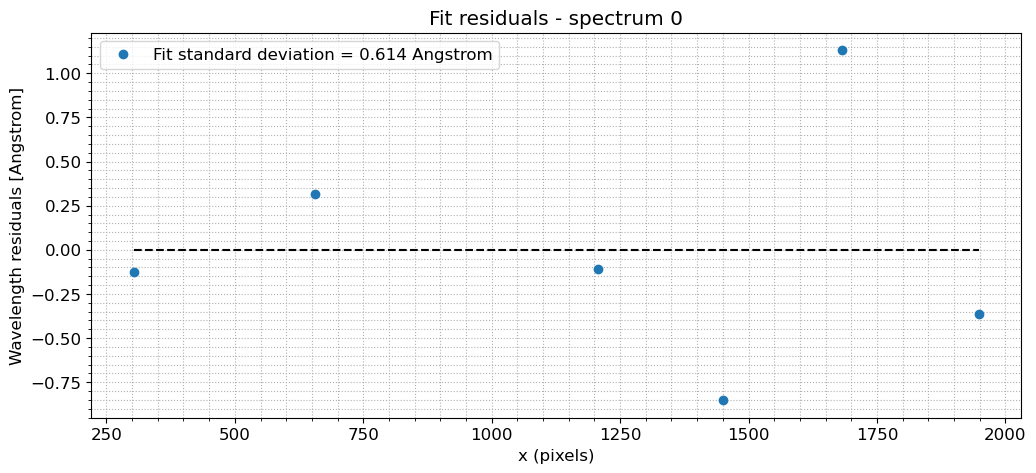

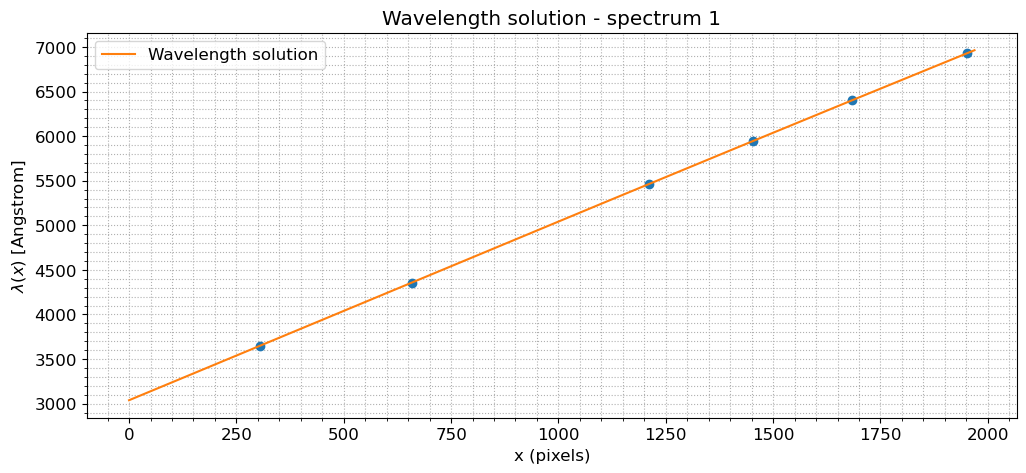

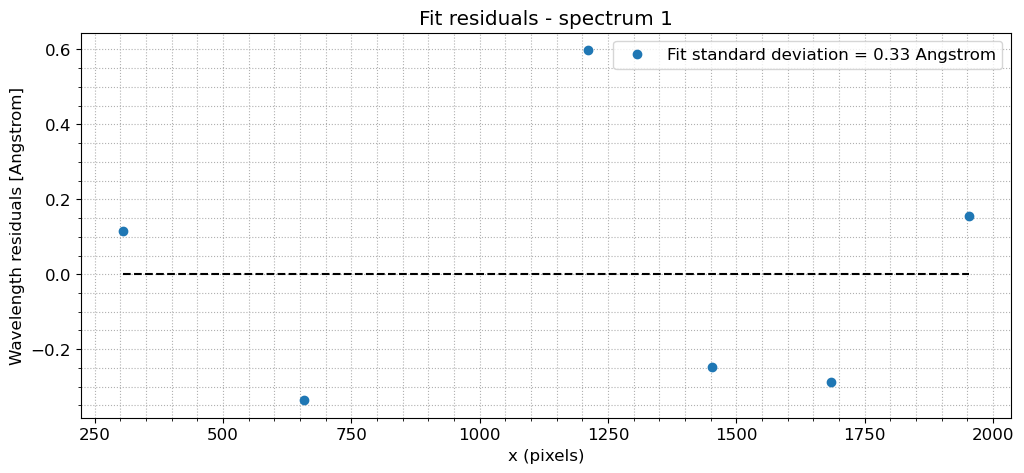

In [65]:
wavelengths_list, wavelengths_fit_std_list = extraction.wavelength_calibration(lamp_peak_positions_list, corresponding_wavelengths, poly_order=3, diagnostic_plots = True)

Remember: the wavelengths must always be in Angstrom!

Here we used a 3rd degree polynomial for the calibration and the residuals look quite good. If you want, you can plot the calibrated spectrum as you prefer:

Text(0.5, 1.0, 'Spectrum 0 calibrated in wavelength')

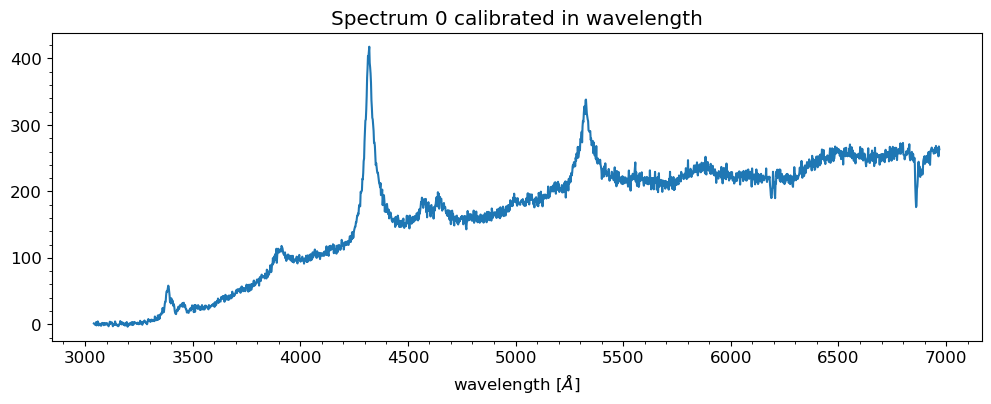

In [66]:
plt.figure(figsize=(12,4))
plt.plot(wavelengths_list[0],spec_extract_list[0])
plt.minorticks_on()
plt.xlabel("wavelength [$\AA$]")
plt.title("Spectrum 0 calibrated in wavelength")

That's it for the wavelength calibration!

## Step 5. Correcting for atmospheric extinction

The observed spectrum was absorbed/scattered by Earth's atmosphere in a wavelength-dependent way and we have to correct for that.

In the `extraction.extinction_correction()` function below we set our observatory as "ctio" (options are "ctio", "kpno", "lapalma", "mko", "mtham", "paranal", "apo") and set *data_type="target"* to correctly select the airmass for the extinction correction. For the standard star, analyzed a few cells below, we have to set *data_type="std_star"*. If your observatory is not listed here, you can set **custom_observatory = "Path/to/file.txt"**, where the string must be the path to a *.txt* file containing the airmass extinction curve. This file must have two columns, the first with the wavelengths **in Angstroms** and the second with the extinction **in mag/airmass**.

The **spline_order** is the interpolation polynomial order for the spline.

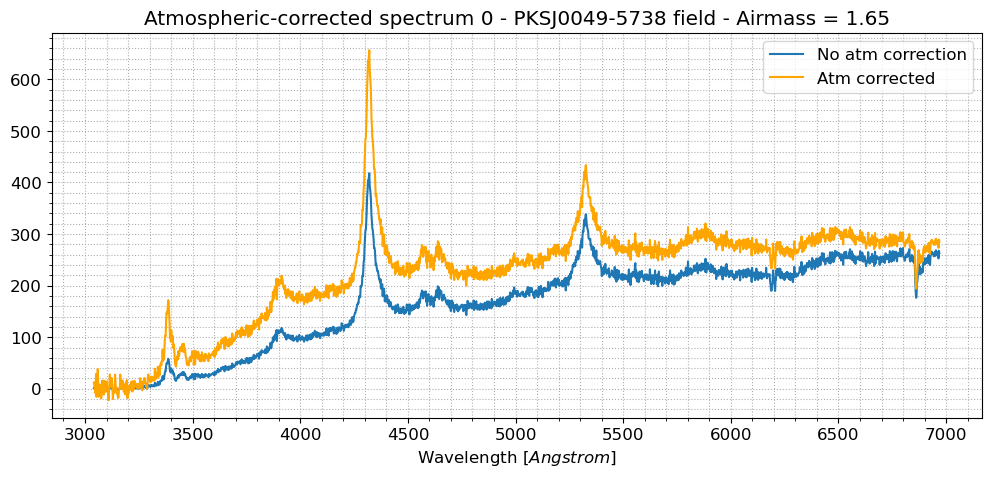

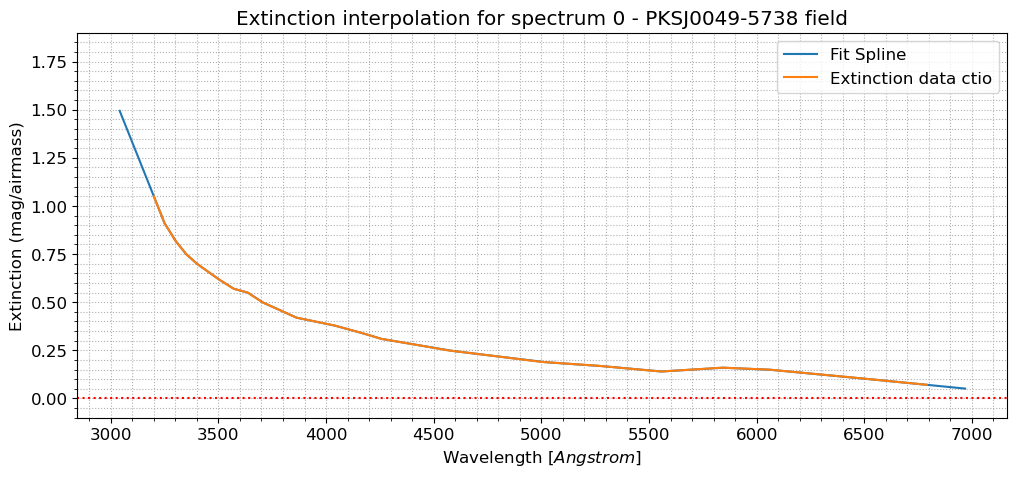

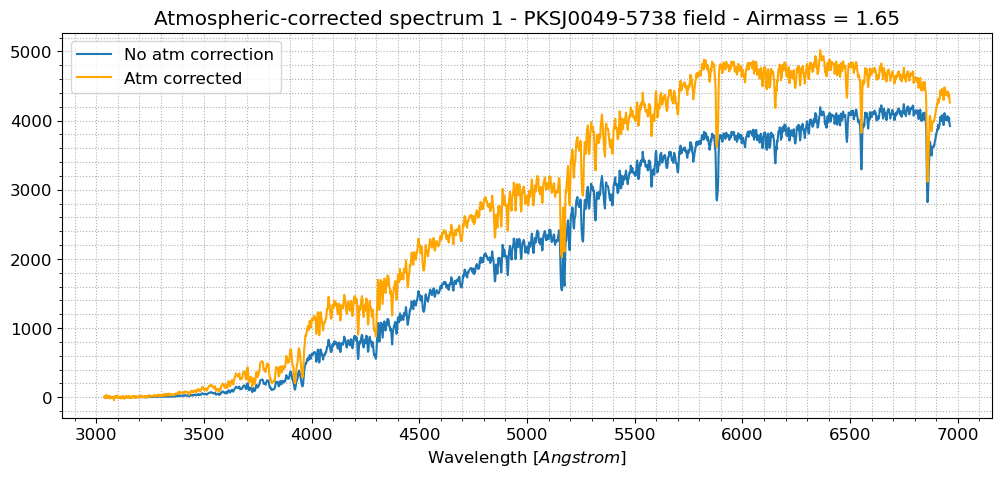

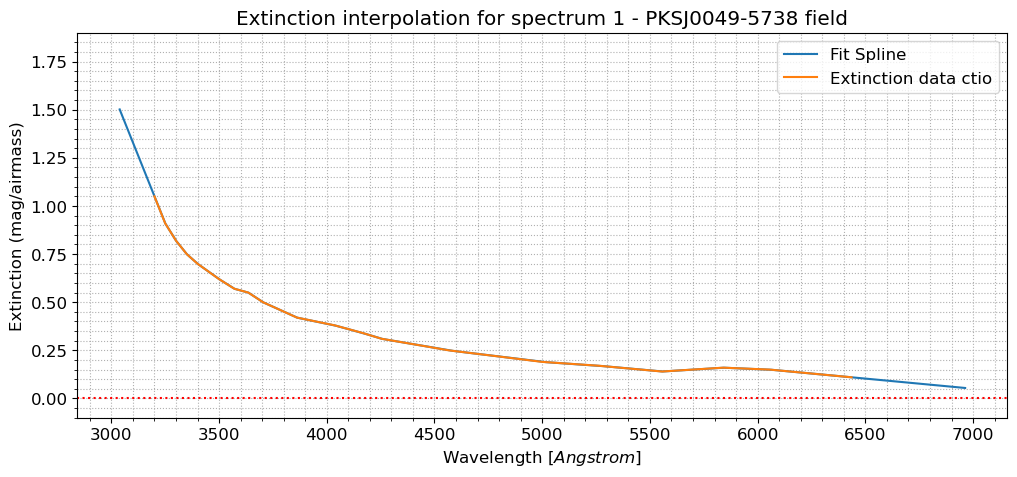

Please cite the work where this extinction curve was measured:
The CTIO extinction curve was originally distributed with IRAF and comes from the work of Stone & Baldwin (1983 MN 204, 347) plus Baldwin & Stone (1984 MN 206, 241). The first of these papers lists the points from 3200-8370A while the second extended the flux calibration from 6056 to 10870A but the derived extinction curve was not given in the paper. The IRAF table follows SB83 out to 6436, the redder points presumably come from BS84 with averages used in the overlap region. More recent CTIO extinction curves are shown as Figures in Hamuy et al (92, PASP 104, 533 ; 94 PASP 106, 566).


In [67]:
spec_atm_corrected_list = extraction.extinction_correction(spec_extract_list, wavelengths_list, observatory=observatory, data_type="target", custom_observatory = None, spline_order = 1, plots = True)

## Step 6. Let's repeat all the process for the standard star

However, let's set all the plotting variables as **False** for simplicity.

In [75]:
spine_std = extraction.tracing(std_data, method="moments", peak_height=100,poly_order=2, xlims=[150,2020], y_pixel_range=15, main_plot = False, plot_residuals=False)

In [73]:
spec_std_list, lamp_spec_list_std, lamp_peak_positions_list_std = extraction.extracting(std_data, spine_std, master_lamp_data="./master_lamp.fits", trace_half_width = 7, shift_y_pixels = 21, lamp_peak_height=1000, peak_distance=150, diagnostic_plots = False, spec_plots = False)

In [70]:
corresponding_wavelengths = [3650.1580, 4046.5650, 4358.3350, 5460.7500, 5790.6700, 6096.1631, 6402.2480, 6929.4673]

In [71]:
wavelengths_std, _ = extraction.wavelength_calibration(lamp_peak_positions_list_std, corresponding_wavelengths, poly_order=3, diagnostic_plots = False)

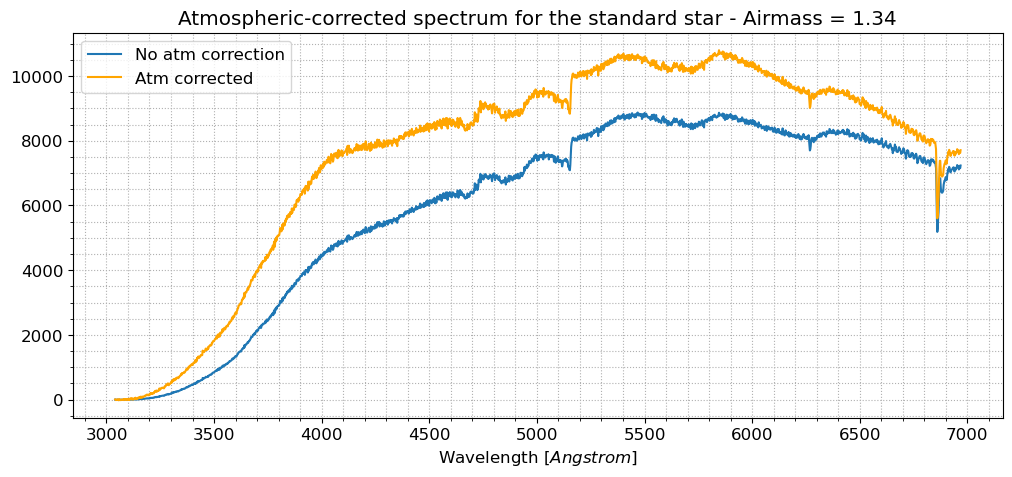

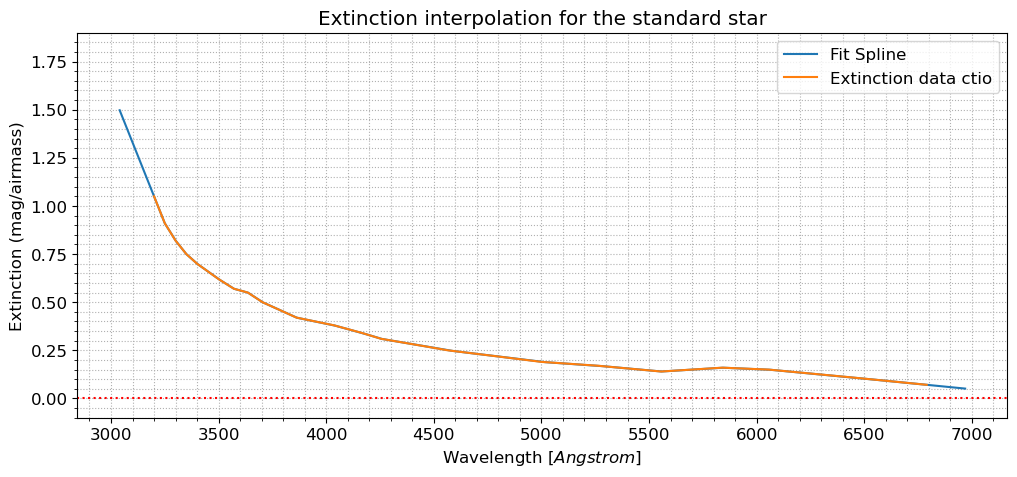

Please cite the work where this extinction curve was measured:
The CTIO extinction curve was originally distributed with IRAF and comes from the work of Stone & Baldwin (1983 MN 204, 347) plus Baldwin & Stone (1984 MN 206, 241). The first of these papers lists the points from 3200-8370A while the second extended the flux calibration from 6056 to 10870A but the derived extinction curve was not given in the paper. The IRAF table follows SB83 out to 6436, the redder points presumably come from BS84 with averages used in the overlap region. More recent CTIO extinction curves are shown as Figures in Hamuy et al (92, PASP 104, 533 ; 94 PASP 106, 566).


In [72]:
spec_atm_corrected_std = extraction.extinction_correction(spec_std_list, wavelengths_std, observatory=observatory, data_type="std_star", custom_observatory = None, spline_order = 1, plots = True)

## Step 7. Finding the standard star archival data

You can find your standard star in our dataset. If you don't know its dataset and name, you can call the function `extraction.list_available_standards()`, as shown below:

In [76]:
extraction.list_available_standards()

Available datasets:
blackbody
bstdscal
ctiocal
ctionewcal
iidscal
irscal
oke1990
redcal
spec16cal
spec50cal
spechayescal


now you can look for the standard star in one of the datasets listed above:

In [77]:
extraction.list_available_standards(std_star_dataset="ctionewcal")

(['l3218.dat',
  'l6248red.dat',
  'eg274red.dat',
  'l9239.dat',
  'l9239red.dat',
  'l745.dat',
  'l3218blue.dat',
  'l6248.dat',
  'l2415.dat',
  'f110.dat',
  'l3864.dat',
  'l6248blue.dat',
  'l7987blue.dat',
  'l1020.dat',
  'l4816red.dat',
  'l2415red.dat',
  'h600red.dat',
  'l4364.dat',
  'eg274blue.dat',
  'l1020red.dat',
  'l3218red.dat',
  'l7379.dat',
  'l4364blue.dat',
  'cd32.dat',
  'h600blue.dat',
  'l377red.dat',
  'eg21red.dat',
  'l9491.dat',
  'l3864red.dat',
  'l9239blue.dat',
  'cd32red.dat',
  'l9491red.dat',
  'l377.dat',
  'f56red.dat',
  'l3864blue.dat',
  'f56.dat',
  'l9491blue.dat',
  'f56blue.dat',
  'eg21.dat',
  'l1788blue.dat',
  'l4816.dat',
  'h600.dat',
  'l1788.dat',
  'l7379red.dat',
  'l745red.dat',
  'l1020blue.dat',
  'eg21blue.dat',
  'l1788red.dat',
  'f110blue.dat',
  'l7379blue.dat',
  'l7987.dat',
  'l4364red.dat',
  'cd32blue.dat',
  'l377blue.dat',
  'standards.men',
  'l4816blue.dat',
  'f110red.dat',
  'l7987red.dat',
  'eg274.dat',
  

## Step 8. Flux calibration

In our case, the standard star dataset is std_star_dataset="ctionewcal", and the data file is std_star_archive_file = "l4364blue.dat". Let's use these values in the function `extraction.std_star_normalization()` below to find the flux-calibrated solution for the standard star:

Fluxes at 50A steps in the blue range 3300-7550A for the tertiary standards of Baldwin andStone derived from the revised calibration of Hamuy et al., 1992, PASP, 104, 533. This dataset also contains the fluxes ofthe tertiaries in the red (6050-10000A) at 50A steps as will be published in PASP (Hamuy et al 1994). The combined fluxes areobtained by gray shifting the blue fluxes to match the red fluxes in the overlap region of 6500A-7500A and averaging the red andblue fluxes in the overlap.  The separate red and blue fluxes may be selected by following the star name with 'red' or 'blue'; i.e. CD 32 blue.


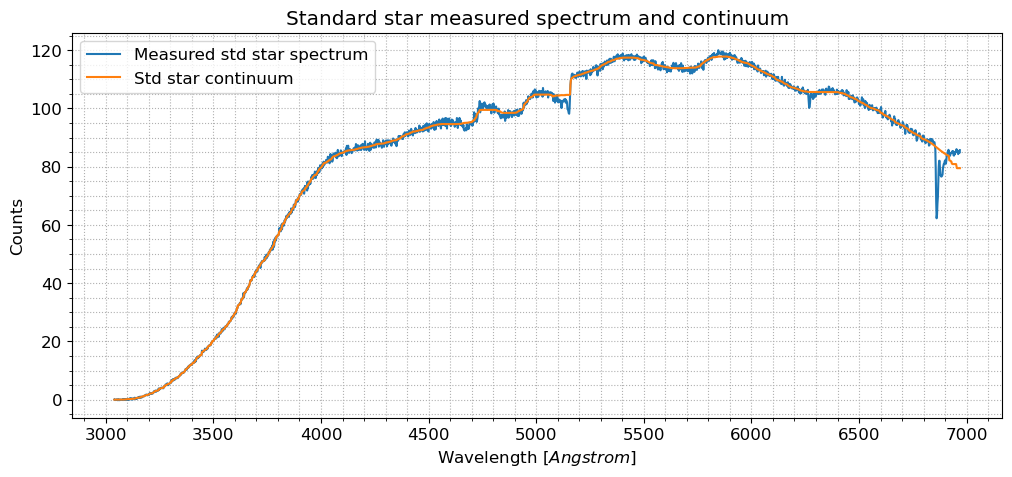

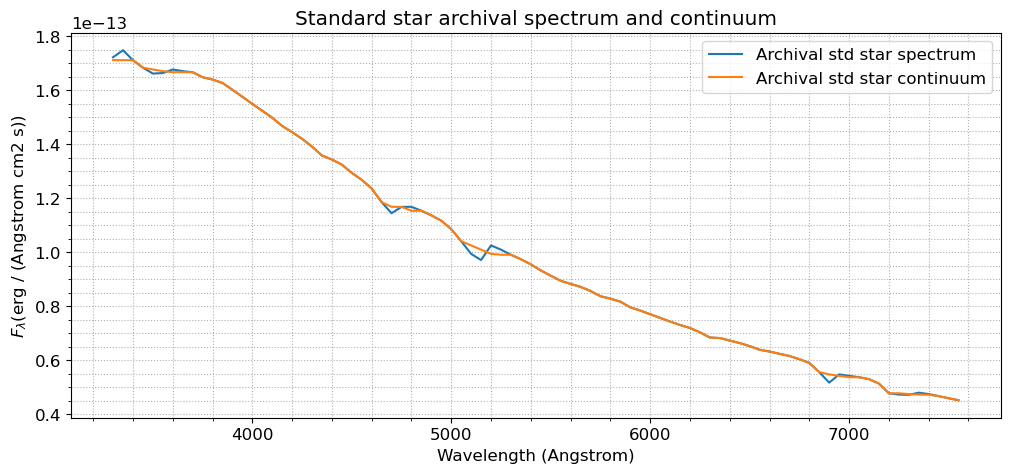

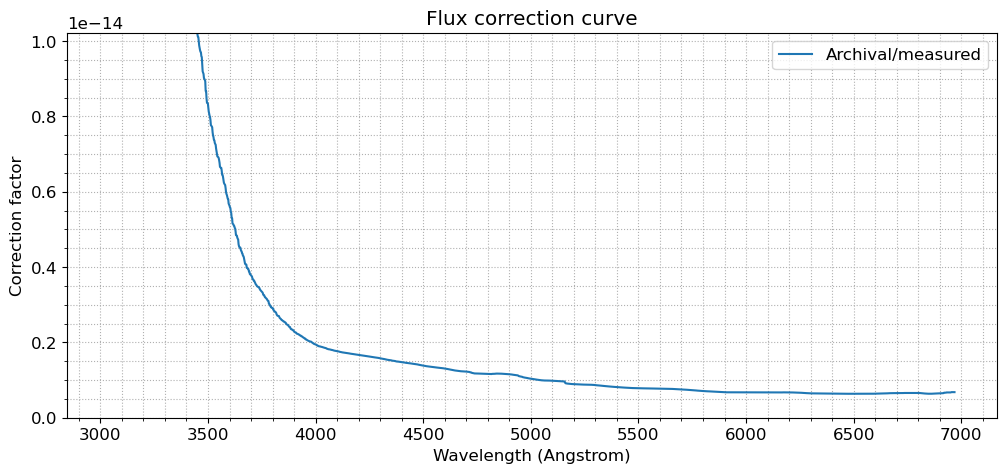

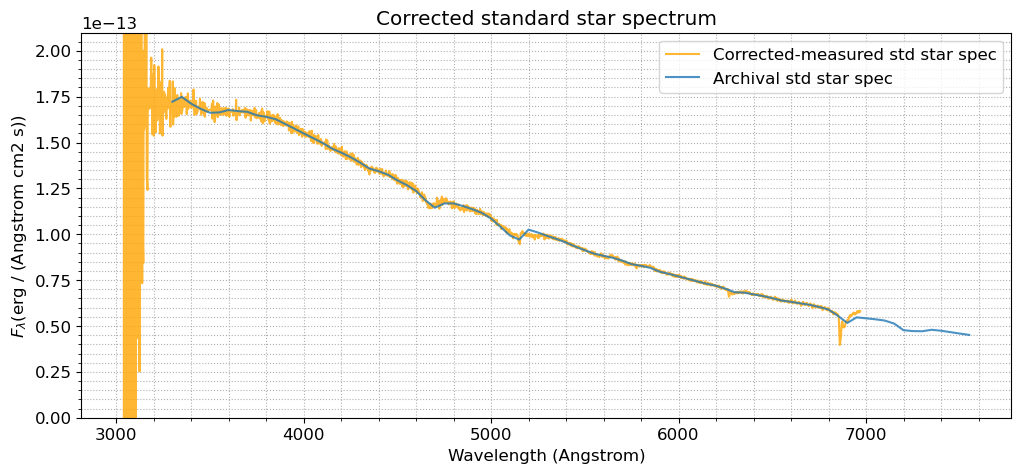

In [85]:
correction_factor = extraction.std_star_normalization(spec_atm_corrected_std, wavelengths_std, std_star_dataset="ctionewcal", std_star_archive_file = "l4364blue.dat", smooth_window = 81, exclude_regions = [[6800,6910]], smooth_window_archive = 5, interpolation_order=2, plots = True)

The other important input variables here are

**smooth_window** = 81: This must be an odd number. This is the number of neighbouring wavelength bins used to extract the standard star continuum with a median filter.

**exclude_regions** = [[6800,6910]]: This is a list of regions (sublists in Angstroms) to be excluded from the measured standard star spectrum when extracting its continuum. For instance, you may want to exclude the regions with telluric absorption lines. Several regions can be excluded by setting **exclude_regions** = [[6800,6910],[7500,7850], [x1,x2]].

**smooth_window_archive** = 5: The same as **smooth_window**, but for the archival spectrum.

From the first two plots above, we see how the measured spectrum is different from the corrected spectrum. The third plot shows the computed correction factor and the final plot shows the calibrated standard star spectrum.

Now let's finaly calibrate the density flux in our spectra:

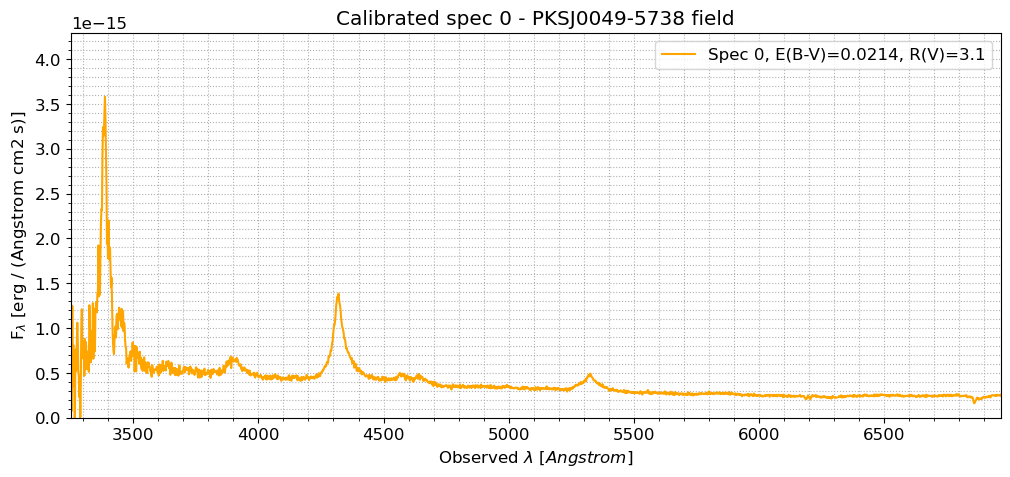

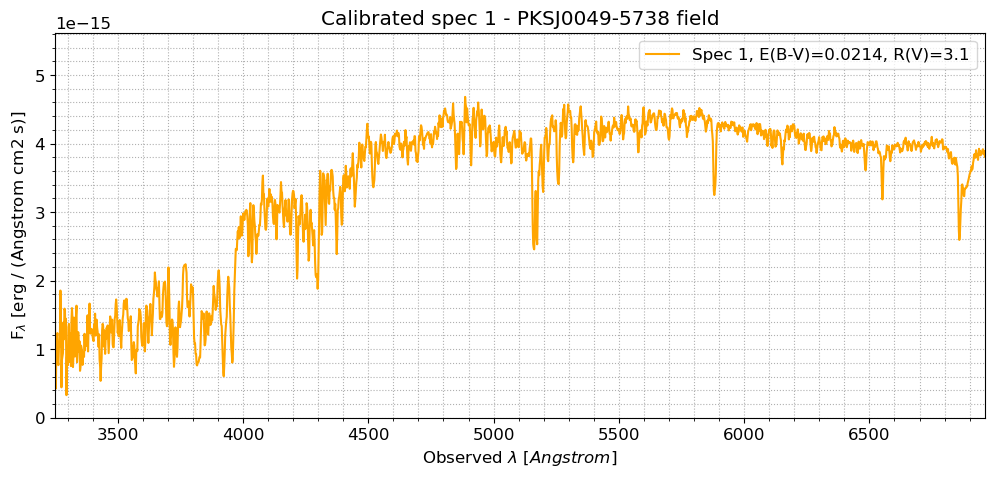

In [92]:
calibrated_flux = extraction.target_flux_calibration(wavelengths_list, spec_atm_corrected_list, correction_factor, reddening = reddening, Rv = None,
                                                     wavelength_cuts = [3250,7500], output_directory = output_directory, save_spec = True, plot = True)

Our target of interest is the blazar shown in *spec 0*. In the *spec 1* we have a foreground star. We could ignore this star since the beginning of the analysis by, e.g., trimming the original data more severely. However, bringing it up to this point is interesting from the didactical point of view.

If Rv = None, it will be automatically set as Rv = 3.1.

The input variable **wavelength_cuts** helps you to cutoff the edges of the spectrum, which may be too noisy.

If **save_spec = True**, this final result will be saved into a ".dat" file in the directory **output_directory**.


That's it for spectral extraction!